<a href="https://colab.research.google.com/github/SenaKymk/HSenaKymk_YZM212_lab_proje/blob/main/5_ForwardAndBackwardPropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bu notebook, **ileri ve geri yayılım algoritmaları** üzerine odaklanır.


Elle normalizasyon yapılan veri seti kullanılarak:  
- **İleri Yayılım (Forward Propagation)** adımı: Modelin öngörülerinin hesaplanması.  
- **Geri Yayılım (Backward Propagation)** adımı: Kayıp fonksiyonunun gradyanı alınarak ağırlıkların güncellenmesi.

Bu süreçte, temel sinir ağı yapısını **ekstra kütüphane kullanmadan** ve aktivasyon fonksiyonları gibi temel bileşenleri kendimiz yazarak uygulama gerçekleştirilmiştir.

In [68]:
import pandas as pd

df = pd.read_csv('/content/data_cleaned.csv')
print(df.head())


   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1             0  3

####  Özellik ve Hedef Ayrımı

Veri setinden, GPA (bağımlı değişken) haricindeki tüm sütunları **bağımsız değişkenler (X)** olarak seçiyoruz.  
Ayrıca, doğrudan GPA ile ilişkili olmayan ve hedef olarak kullanılmayan `StudentID` ve `GradeClass` gibi sütunları çıkararak modelimizi **gereksiz özniteliklerden** arındırıyoruz.


In [69]:
df = df.drop(columns=["StudentID","GradeClass"])

X = df.drop(columns=["GPA"]).values
y = df["GPA"].values.reshape(-1, 1)

#### Elle Normalizasyon (Z-Score)

Bu adımda, herhangi bir hazır kütüphane kullanmadan, özellikleri  **normalize** ediyoruz (Z-score standardizasyonu):

- Her özelliğin ortalamasını (`X_mean`) ve standart sapmasını (`X_std`) hesaplıyoruz.
- Ardından, her değeri \((X - \mu) / \sigma\) formülüne göre normalize ederek **ortalaması sıfır ve standart sapması bir** olan yeni bir özellik matrisi (`X_scaled`) elde ediyoruz.


In [70]:
import numpy as np
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_scaled = (X - X_mean) / X_std

#### 🔧 Ağırlık ve Bias Başlatma

İleri ve geri yayılımda kullanılacak **ağırlık (W)** ve **bias (b)** matrislerini başlatıyoruz:

Bu adım, modelin **öğrenmeye başlaması için başlangıç parametrelerini** hazırlar.


In [71]:
import numpy as np

np.random.seed(42)

input_size = X.shape[1] #Özellik sayısı kadar giriş nöronu
hidden_size = 8 #Gizli katmandaki nöron sayısı
output_size = 1 #Çıkış katmanı sadece GPA tahmini olduğu için 1 nöron.

W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))


####  ReLU Aktivasyon Fonksiyonu ve Türevi

Sinir ağı mimarisinde **ReLU (Rectified Linear Unit)** aktivasyon fonksiyonu kullanılmaktadır:
relu: negatif değerleri sıfırlar ve pozitif değerleri olduğu gibi bırakır.  


relu_derivateive: Backpropagation’da kullanılmak üzere **türev** değerlerini döndürür.

Bu iki fonksiyon, gizli katmandaki aktivasyon hesaplamalarında ve geri yayılım algoritmasında yer alır.


In [72]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)


####  İleri Yayılım (Forward Propagation)

Bu fonksiyon, verilerin ağ katmanlarından geçerek **nihai tahmini** üretmesini sağlar.

Fonksiyon çıktısı:  
- **Z1**: Gizli katman lineer çıktı (ReLU’dan önce)  
- **A1**: Gizli katman aktivasyonu (ReLU’dan sonra)  
- **Z2**: Çıkış katmanı tahmini (modelin tahmini)

Bu fonksiyon, her veri örneği için **ileri yönde hesaplamayı** gerçekleştirir.

In [73]:
def forward(X, W1, b1, W2, b2):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    return Z1, A1, Z2


####  Kayıp Fonksiyonu (Loss)

Modelimizin ne kadar iyi tahmin yaptığını değerlendirmek için **Mean Squared Error (MSE)** tabanlı bir kayıp fonksiyonu kullanıyoruz.

Bu kayıp değeri, modelin tahmin performansını ölçer ve **gradient descent** adımlarında kullanılır.  
Eğer kayıp düşükse modelin doğru tahmin yaptığı anlamına gelir.


In [74]:
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return (1 / (2 * m)) * np.sum((y_true - y_pred) ** 2)


####  Geri Yayılım (Backward Propagation)

Modelin kayıp fonksiyonuna göre **gradyanlarını** (türevi) hesaplayarak ağırlık ve bias değerlerini güncelleriz.  
Bu fonksiyon, **zincir kuralı** yardımıyla katman katman geriye doğru türev hesaplar.

Sonuçta elde edilen gradyanlar (`dW1`, `db1`, `dW2`, `db2`) ile parametreler güncellenir.  
Bu, **modelin öğrenmesi için temel adımdır**.


In [75]:
def backward(X, y, Z1, A1, Z2, W2):
    m = y.shape[0]
    dZ2 = (Z2 - y) / m
    dW2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2


####  Parametre Güncelleme (Gradient Descent)

Bu adımda, geri yayılım sonucunda elde edilen gradyanlar kullanılarak ağırlık ve bias değerleri güncellenir.

  Bu güncellemeler, modelin **hataları azaltarak** daha iyi tahmin yapabilmesini sağlar


In [76]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2


####  Eğitim Döngüsü ve Kayıp İzleme

Bu döngüde model, belirlenen epoch sayısı boyunca (1000) eğitim alır

Görüldüğü gibi:
- **Başlangıç Loss’u**: 2.2361 (yüksek hata)
- **Epoch 900 Loss’u**: 0.0798 (çok daha düşük hata)

Bu, modelin hataları azalttığını ve iyi bir şekilde öğrendiğini gösterir


In [77]:
epochs = 1000
lr = 0.01
cost_history = []


for i in range(epochs):
    # Forward
    Z1, A1, Z2 = forward(X_scaled, W1, b1, W2, b2)

    # Loss
    loss = compute_loss(y, Z2)

    cost_history.append(loss)
    # Backward
    dW1, db1, dW2, db2 = backward(X_scaled, y, Z1, A1, Z2, W2)

    # Güncelleme
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

    # İzleme
    if i % 100 == 0:
        print(f"Epoch {i} | Loss: {loss:.4f}")


Epoch 0 | Loss: 2.2361
Epoch 100 | Loss: 0.6609
Epoch 200 | Loss: 0.4484
Epoch 300 | Loss: 0.4135
Epoch 400 | Loss: 0.3891
Epoch 500 | Loss: 0.3378
Epoch 600 | Loss: 0.2513
Epoch 700 | Loss: 0.1651
Epoch 800 | Loss: 0.1097
Epoch 900 | Loss: 0.0798


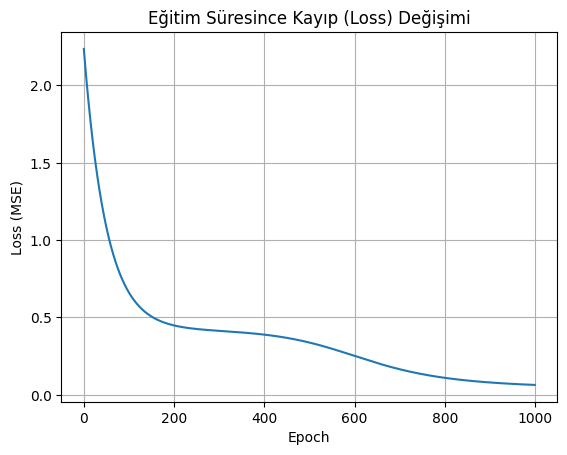

In [78]:
import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Eğitim Süresince Kayıp (Loss) Değişimi")
plt.grid(True)
plt.show()


Modelin çıktısı (tahmin edilen GPA değerleri) elde edilmiş ve mean_squared_error metriği kullanılarak final MSE (Ortalama Kare Hata) hesaplanmıştır. Sonuç olarak modelin ortalama hatası **0.1277** gibi oldukça düşük bir değerde bulunmuştur. Bu, modelin veriye **iyi uyum sağladığını ve doğru tahminleme** yeteneğine sahip olduğunu göstermektedir.

In [79]:
_, _, y_pred = forward(X_scaled, W1, b1, W2, b2)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, y_pred)
print("Final MSE:", mse)


Final MSE: 0.12777162192202493


🔵 **Mavi Noktalar:** Modelinin tahmin ettiği GPA değerleri ve gerçek GPA değerleri.

🔴 **Kırmızı Kesikli Çizgi:** İdeal bir tahmin hattı (gerçek ve tahmin eşit olsaydı, tüm noktalar burada olurdu).

Grafik çok iyi; model hatasını minimumda tutmuş

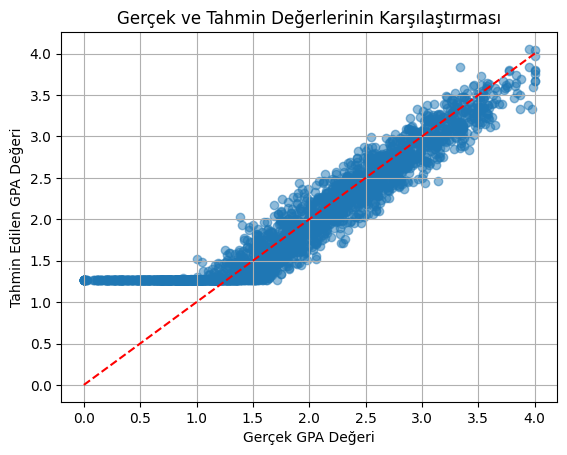

In [80]:
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Gerçek GPA Değeri")
plt.ylabel("Tahmin Edilen GPA Değeri")
plt.title("Gerçek ve Tahmin Değerlerinin Karşılaştırması")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # y=x hattı
plt.grid(True)
plt.show()

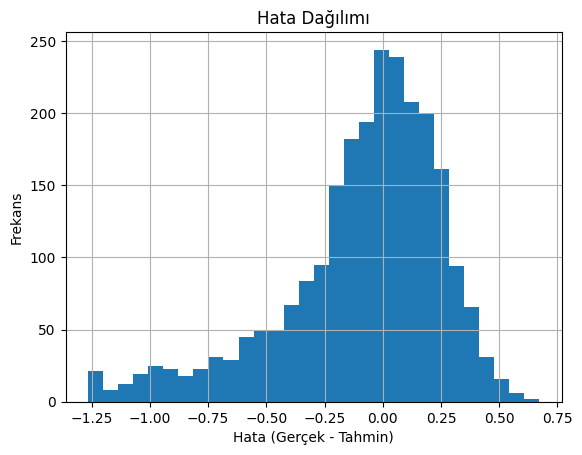

In [81]:
plt.hist(y - y_pred, bins=30)
plt.xlabel("Hata (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.title("Hata Dağılımı")
plt.grid(True)
plt.show()



Veri setindeki GPA değerlerini tahmin etmek için ileri ve geri yayılım algoritmaları kullanıldı.

Elle normalizasyon (Z-score), ReLU aktivasyon fonksiyonu, MSE (Ortalama Kare Hata) gibi temel bileşenler kütüphane sınıfları kullanılmadan Python’da uygulandı.

Eğitim sonunda loss değeri başlangıçta 2.2361 iken, 900. epoch’ta 0.0798’e kadar düştü.

Son MSE değeri 0.1277, modelin GPA tahmini konusunda yüksek doğruluğa ulaştığını gösteriyor.